In [64]:
### PREPROCESSING (Imports) - Import necessary libraries for preprocessing
from typing import List, Dict, Tuple
from typing import overload, Literal, Union

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.cluster import Birch
from hdbscan import HDBSCAN

from sklearn.metrics import davies_bouldin_score, accuracy_score, classification_report, confusion_matrix

In [2]:
###  PREPROCESSING - Read CSV file & Future Formatting
df_data = pd.read_csv("data.csv")
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:.2f}".format

In [3]:
###  PREPROCESSING (Function definitions) - Data introduction
# Identify unnecessary and target columns
DROP_LABELS = ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Timestamp"]
TARGET_LABELS = ["Label", "Traffic Type", "Traffic Subtype"]

# Split training and testing data
def split_data(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame]:
    X = df.copy()
    Y = df[target]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1/3)
    return x_train, x_test, y_train, y_test

# Sampling

def oversample(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame]:
    x = df.drop(columns=target)
    y = df[target]

    ROS = RandomOverSampler(sampling_strategy="auto")
    x_res, y_res = ROS.fit_resample(x, y)
    return x_res, y_res

def sampling(df: pd.DataFrame, rate: float, cap1=0, cap2=0, notext=False) -> pd.DataFrame:
    if notext == False:
        print("Dataset before sampling has", df.shape[0], "rows and", df.shape[1], "columns")
        print("Sampling ...")

    if cap1 != 0:
        subtype_counts = df["Traffic Subtype"].value_counts()  # All the traffic subtypes
        if cap2 != 0:
            subtypes_sampling1 = subtype_counts[(subtype_counts > cap1) & (subtype_counts < 10*cap2)].index
            subtypes_sampling2 = subtype_counts[subtype_counts >= 10*cap2].index
        
        else:
             subtypes_sampling = subtype_counts[subtype_counts > cap1].index
        subtypes_nosampling = subtype_counts[subtype_counts <= cap1].index # All the traffic subtypes with under x rows
        
        if cap2 != 0:
            df_sampling1 = df[df["Traffic Subtype"].isin(subtypes_sampling1)]
            df_sampled1 = df_sampling1.sample(frac=rate)
            df_sampling2 = df[df["Traffic Subtype"].isin(subtypes_sampling2)]
            df_sampled2 = df_sampling2.sample(frac=rate/10)
            df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
            df_final =  pd.concat([df_sampled1, df_sampled2, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

        else:
            df_sampling = df[df["Traffic Subtype"].isin(subtypes_sampling)]
            df_sampled = df_sampling.sample(frac=rate)
            df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
            df_final =  pd.concat([df_sampled, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

    else:
        df_final = df.sample(frac=rate)
        
    if notext == False:
        print("Dataset after sampling has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final.sample(frac=1, ignore_index=True)

# Drop unnecessary data
def drop_unnecessary(df: pd.DataFrame) -> pd.DataFrame:
    print("Dataset before removing unnecessary data has", df.shape[0], "rows and", df.shape[1], "columns")
    print("Removing unnecessary data ...")
    df_final =  df.drop(columns=DROP_LABELS)
    print("Dataset after removing unnecessary data has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Data presentation
def present(df: pd.DataFrame) -> pd.DataFrame:
    print("\n\nSampled dataset:")
    print("Dataset after uniform target sampling has", df.shape[0], "rows and", df.shape[1], "columns")

    display(df.head())
    display(df.tail())

    df_details = df.describe()
    display(df_details.T)

    display(df.groupby(["Label"]).size().reset_index(name="Counts"))
    display(df.groupby(["Traffic Type"]).size().reset_index(name="Counts"))
    
    return df_details

In [167]:
###  PREPROCESSING (Function definitions) - Correlation, target correlation and importaant metrics
LABEL_MAPPER = {"Malicious": 1, "Benign": 0}
TYPES_MAPPER = {"Audio": 0, "Background": 1, "Text": 2, "Video": 3, "Bruteforce": 4, "DoS": 5, "Information Gathering": 6, "Mirai": 7}
SUBTYPES_MAPPER = {
    "Audio": 0, "Background": 1, "Text": 2, "Video HTTP": 3, "Video RTP": 4, "Video UDP": 5, "Bruteforce DNS": 6, "Bruteforce FTP": 7, "Bruteforce HTTP": 8,
    "Bruteforce SSH": 9, "Bruteforce Telnet": 10, "DoS ACK": 11, "DoS CWR": 12, "DoS ECN": 13, "DoS FIN": 14, "DoS HTTP": 15, "DoS ICMP": 16, "DoS MAC": 17,
    "DoS PSH": 18, "DoS RST": 19, "DoS SYN": 20, "DoS UDP": 21, "DoS URG": 22, "Information Gathering": 23, "Mirai DDoS ACK": 24, "Mirai DDoS DNS": 25,
    "Mirai DDoS GREETH": 26, "Mirai DDoS GREIP": 27, "Mirai DDoS HTTP": 28, "Mirai DDoS SYN": 29, "Mirai DDoS UDP": 30, "Mirai Scan Bruteforce": 31
    }

# Targets to numerical
def labels_to_numerical(df: pd.DataFrame, mapper: Dict[str, int]) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].map(mapper)
    return df_copy

def ttypes_to_numerical(df: pd.DataFrame, mapper: Dict[str, int]) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Type"] = df_copy["Traffic Type"].map(mapper)
    return df_copy

def subtypes_to_numerical(df: pd.DataFrame, mapper: Dict[str, int]) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Subtype"] = df_copy["Traffic Subtype"].map(mapper)
    return df_copy

#  PREPROCESSING - Correlation and overloading for different return types
@overload
def correlation(df_numerical: pd.DataFrame, target: str, with_target: Literal[True]) -> Tuple[pd.DataFrame, List[str]]: ...
@overload
def correlation(df_numerical: pd.DataFrame, target: str, with_target: Literal[False]) -> pd.DataFrame: ...
@overload
def correlation(df_numerical: pd.DataFrame, target: str, with_target: bool) -> Union[pd.DataFrame, Tuple[pd.DataFrame, List[str]]]: ...
    
def correlation(df_numerical: pd.DataFrame, target: str, with_target: bool) -> Union[pd.DataFrame, Tuple[pd.DataFrame, List[str]]]:
    df_copy = df_numerical.copy()
    df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())

    if with_target == True:
        important_metrics = []
        cor = df_norm.corr(numeric_only=True).filter([target])

        for r in cor.index.tolist():
            if abs(cor.at[r, target]) > 0.25:
                important_metrics.append(r)

        print(len(important_metrics) - 2, "Metrics with high correlation with Label")
        return cor, important_metrics

    else:
        return df_norm.corr(numeric_only=True)
    

In [5]:
###  PREPROCESSING (Function definitions) - Data Visualization
# Create heatmap from correlation Pandas Dataframes
def heatmap(corr_dict: dict, title: str, with_target=False) -> None:
    print("Generating heatmap ...")
    
    if with_target == True:
        final_corr = pd.DataFrame()
        for target in corr_dict.keys(): final_corr[target] = corr_dict[target]
        final_corr = final_corr.T
        plt.figure(figsize=(30, 5))
        sns.heatmap(final_corr, cmap="coolwarm", square=True, cbar=False)
        plt.xticks(rotation = 65, ha = "right")

    else:
        final_corr = corr_dict["Correlation"]
        plt.figure(figsize=(30, 20))
        sns.heatmap(final_corr, cmap="coolwarm", square=True)

    plt.title(title)
    plt.show()

# Create boxplot diagram to showcase target differences
def boxplot(df: pd.DataFrame, title: str, y_lim_bot: float, y_lim_top: float, x_labels: list) -> None:
    print("Generating boxplot ...")
    df_copy = df.copy()
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_copy)
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df_scaled)
    plt.ylim((y_lim_bot, y_lim_top))
    plt.xticks(rotation = 65, ha = "right", labels=x_labels, ticks=[i for i in range(len(x_labels))])
    plt.title(title)
    plt.show()

# Create barplot to showcase certain values
def barplot(x, y, title: str) -> None:
    print("Generating barplot ...")
    plt.figure(figsize=(15, 5))
    sns.barplot(x=x, y=y)
    plt.ylim((-1, 1))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.show()



In [6]:
###  PREPROCESSING (Function definitions) - Dimensionality Reduction
PCA_COLS = [
    "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17",
    "PC18", "PC19", "PC20", "PC21", "PC22", "PC23", "PC24", "PC25", "PC26", "PC27", "PC28", "PC29", "PC30"
    ]

def dim_reduction(df: pd.DataFrame, N: int, method: str, notext=False) -> pd.DataFrame:
    if method == "PCA":
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)

        pca = PCA(n_components=N)
        principal_components = pca.fit_transform(df_scaled)
        df_final = pd.DataFrame(data=principal_components, columns=PCA_COLS[:N])

        if notext == False:
            print("PCA METHOD --> Cumulative variance:", pca.explained_variance_ratio_.cumsum()[-1])
    
    return df_final

In [175]:
###  PREPROCESSING (Function definitions) - Clustering
# BIRCH Algorithm
def BIRCH_clustering(df: pd.DataFrame, N_clusters: int, threshold=0.5) -> Tuple[pd.DataFrame, Birch]:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    model = Birch(n_clusters=N_clusters, threshold=threshold)
    model.fit(df_scaled)
    df["Cluster"] = model.labels_
    print(df["Cluster"].nunique(), "Clusters")

    cluster_index = davies_bouldin_score(df, model.labels_)
    print("Davies-Bouldin Index:", cluster_index)
    return df, model

# HDBSCAN Algorithm
def HDBSCAN_clustering(df: pd.DataFrame, minimum_cluster_size=5) -> Tuple[pd.DataFrame, HDBSCAN]:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    model = HDBSCAN(min_cluster_size=minimum_cluster_size)
    clusters = model.fit_predict(df_scaled)
    df["Cluster"] = clusters
    df_clean = df[df["Cluster"] != -1]
    print(df_clean["Cluster"].nunique(), "Clusters")
    
    clusters_clean = df_clean["Cluster"].to_numpy()
    cluster_index = davies_bouldin_score(df_clean, clusters_clean)
    print("Davies-Bouldin Index:", cluster_index)
    return df, model

# Evaluation of clusters
def evaluate_clusters(df: pd.DataFrame, target: str, subtarget: str, targets_n: int, cluster_ratio_cap=0.2, keep_problematic=False) -> pd.DataFrame:
    df_copy = df.copy()

    prediction_list = []
    counts = {}
    problematic_count = 0
    problematic_idx_count = {i: 0 for i in range(targets_n)}
    problematic_pop = 0
    empty_clusters = 0
    total_pop = len(df)
    total_clusters = df["Cluster"].nunique()
    target_total_pop = {i: 0 for i in range(targets_n)}
    target_actual_pop = {i: 0 for i in range(targets_n)}

    for cluster_id in range(total_clusters):
        class_counts = [len(df[(df["Cluster"] == cluster_id) & (df[target] == j)]) for j in range(targets_n)]
        if sum(class_counts) == 0:
            empty_clusters += 1
            continue
        dominant_class = np.argmax(class_counts)
        dominant_count = class_counts[dominant_class]
        other_count = sum(class_counts) - dominant_count
        prediction_list.append(dominant_class)
        if dominant_count == 0:
            print(class_counts)
            continue
        ratio = other_count / (dominant_count + other_count)
        if ratio > cluster_ratio_cap:  # Condition to identify problematic cluster
            problematic_count += 1
            problematic_pop += sum(class_counts)
            problematic_idx_count[dominant_class] += 1
            if keep_problematic == False:
                df_copy = df_copy.drop(df_copy[df_copy["Cluster"] == cluster_id].index)
        target_total_pop[dominant_class] += sum(class_counts)

    for i in range(targets_n):
        counts[i] = prediction_list.count(i)

    for i in range(targets_n):
        target_actual_pop[i] = len(df[df[target] == i])

    print("Problematic Cluster - Ratio: {0:.3f}%".format(problematic_count / total_clusters * 100))  # Ratio of clusters that are problematic
    print("Population that belongs to Problematic Clusters - Ratio: {0:.3f}%".format(problematic_pop / total_pop * 100))  # Ratio of total population that belongs to problematic clusters
    print("Clusters assigned to each {0}: {1}".format(target, counts))  # Amount of clusters that each target is assigned
    print("Problematic Clusters assigned to each {0}: {1}".format(target, problematic_idx_count)) # Amount of problematic clusters that each target is assigned
    print("Total Clusters:", total_clusters)  # Total number of clusters
    print("Empty clusters:", empty_clusters)  # Total number of empty clusters
    print("Total Population predicted per Target:", target_total_pop)  # Total population that was predicted for each target
    print("Real Population per Target:", target_actual_pop) # Real population of each target

    df_plot_x = df.groupby("Cluster")[target].mean()
    df_plot_y = df.groupby("Cluster")[subtarget].mean()

    plt.figure(figsize=(10, 6))
    plt.scatter(df_plot_x.values, df_plot_y.values, c="red", marker="x", s=100, label="Cluster Centers")
    if target == "Label":
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.5, 7.5))
    elif target == "Traffic Type":
        plt.xlim((-0.5, 7.5))
        plt.ylim((-1, 32))
    plt.xlabel(target)
    plt.ylabel(subtarget)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df_copy
    

In [82]:
### PREPROCESSING (Function definitions) - Generate training data from clusters
def format_data(df: pd.DataFrame, target: str, targets_n: int) -> pd.DataFrame:
    cluster_counts = {}
    final_samples = []

    df_grouped = df.groupby("Cluster")
    df_mean = df_grouped.mean()
    df_labels = df_grouped[target].agg(lambda x: x.mode()[0])
    df_mean[target] = df_labels

    for i in range(targets_n): cluster_counts[i] = df[df[target] == i]["Cluster"].value_counts().count()  # Clusters per target
    most_clusters = max(cluster_counts.values())  # Maximum clusters for one target

    for i in range(targets_n):
        n_added = most_clusters - cluster_counts[i]  # Samples to add for specific target
        df_target_data = df[df[target] == i]  # Data of specific target
        target_samples = df_target_data.sample(n=n_added, ignore_index=True, replace=True)  # Sampled data to add for specific target
        mean_rows = df_mean[df_mean[target] == i]  # Means of clusters for specific target
        final_samples.append(pd.concat([target_samples, mean_rows], ignore_index=True))

    df_sampled = pd.concat(final_samples, ignore_index=True)
    df_final = df_sampled.sample(frac=1, ignore_index=True).drop(columns=["Cluster"])

    return df_final

In [67]:
### PREPROCESSING (Implementation) - Initial undersampling/oversampling remove excess metrics and duplicates in order to create plots in reasonable time, present data
ttype_list = ["Audio", "Background", "Text", "Video", "Bruteforce", "DoS", "Information Gathering", "Mirai"]

# Undersample large traffic subtypes to decrease data size
df_sampled = sampling(df_data, rate=0.005, cap1=5000, cap2=0)
df_sampled = drop_unnecessary(df_sampled)

# Split between training and testing data
split_list = split_data(df_sampled, "Label")
df_train = split_list[0]
df_test = split_list[1]

df_smoothed, y_train = oversample(df_train, "Traffic Type")
df_smoothed["Traffic Type"] = y_train

df_test, y_test = oversample(df_test, "Traffic Type")
df_test["Traffic Type"] = y_test

# Undersample again to get to desired data size and introduce slight randomizations
df = sampling(df_smoothed, rate=0.8, notext=True)

# Present data
df_details = present(df)

Dataset before sampling has 8656767 rows and 86 columns
Sampling ...
Dataset after sampling has 61467 rows and 86 columns
Dataset before removing unnecessary data has 61467 rows and 86 columns
Removing unnecessary data ...
Dataset after removing unnecessary data has 61467 rows and 80 columns


Sampled dataset:
Dataset after uniform target sampling has 160154 rows and 80 columns


Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      6.00     1217451.00              1.00               1.00   
1      6.00    52094234.00              4.00               0.00   
2      6.00    10038091.00              7.00               6.00   
3      6.00      237493.00              1.00               1.00   
4      6.00     2512275.00              1.00               1.00   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                       50.00                        0.00   
1                     1980.00                        0.00   
2                       26.00                      112.00   
3                      500.00                        0.00   
4                       50.00                        0.00   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                  50.00                  50.00                   50.00   
1                 500.00                 480.00                  495.00   
2                  14.00                   0.00                    3.71   
3                 500.00                 500.00                  500.00   
4                  50.00                  50.00                   50.00   

   Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                   0.00                   0.00                   0.00   
1                  10.00                   0.00                   0.00   
2                   6.37                  77.00                   0.00   
3                   0.00                   0.00                   0.00   
4                   0.00                   0.00                   0.00   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                    0.00                   0.00         41.07   
1                    0.00                   0.00         38.01   
2                   18.67                  31.82         13.75   
3                    0.00                   0.00       2105.33   
4                    0.00                   0.00         19.90   

   Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  \
0            1.64     1217451.00          0.00    1217451.00    1217451.00   
1            0.08    17364744.67   11320993.83   30218709.00    8877034.00   
2            1.30      836507.58    2888225.17   10007852.00         25.00   
3            8.42      237493.00          0.00     237493.00     237493.00   
4            0.80     2512275.00          0.00    2512275.00    2512275.00   

   Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1    52094234.00   17364744.67  11320993.83  30218709.00   8877034.00   
2    10031906.00    1671984.33   4085699.36  10011880.00        25.00   
3           0.00          0.00         0.00         0.00         0.00   
4           0.00          0.00         0.00         0.00         0.00   

   Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1           0.00          0.00         0.00         0.00         0.00   
2    10035640.00    2007128.00   4475999.15  10014037.00       925.00   
3           0.00          0.00         0.00         0.00         0.00   
4           0.00          0.00         0.00         0.00         0.00   

   Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
0           0.00           0.00           0.00           0.00   
1           0.00           0.00           0.00           0.00   
2           0.00           0.00           0.00           0.00   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
0              20.00              20.00           0.82           0.82   
1             100.00               0.00           0.08  

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
160149      6.00     1996113.00              1.00               1.00   
160150      6.00     1211078.00              1.00               1.00   
160151      6.00     2252960.00              2.00               1.00   
160152      6.00     1622554.00              2.00               1.00   
160153      6.00          37.00              2.00               0.00   

        Total Length of Fwd Packet  Total Length of Bwd Packet  \
160149                       50.00                        0.00   
160150                       50.00                        0.00   
160151                        0.00                        0.00   
160152                        0.00                        0.00   
160153                        0.00                        0.00   

        Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
160149                  50.00                  50.00                   50.00   
160150                  50.00                  50.00                   50.00   
160151                   0.00                   0.00                    0.00   
160152                   0.00                   0.00                    0.00   
160153                   0.00                   0.00                    0.00   

        Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
160149                   0.00                   0.00                   0.00   
160150                   0.00                   0.00                   0.00   
160151                   0.00                   0.00                   0.00   
160152                   0.00                   0.00                   0.00   
160153                   0.00                   0.00                   0.00   

        Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
160149                    0.00                   0.00         25.05   
160150                    0.00                   0.00         41.29   
160151                    0.00                   0.00          0.00   
160152                    0.00                   0.00          0.00   
160153                    0.00                   0.00          0.00   

        Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
160149            1.00     1996113.00          0.00    1996113.00   
160150            1.65     1211078.00          0.00    1211078.00   
160151            1.33     1126480.00    1589431.79    2250378.00   
160152            1.85      811277.00    1139488.44    1617017.00   
160153        54054.05          37.00          0.00         37.00   

        Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
160149    1996113.00           0.00          0.00         0.00         0.00   
160150    1211078.00           0.00          0.00         0.00         0.00   
160151       2582.00     2250378.00    2250378.00         0.00   2250378.00   
160152       5537.00     1617017.00    1617017.00         0.00   1617017.00   
160153         37.00          37.00         37.00         0.00        37.00   

        Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
160149         0.00           0.00          0.00         0.00         0.00   
160150         0.00           0.00          0.00         0.00         0.00   
160151   2250378.00           0.00          0.00         0.00         0.00   
160152   1617017.00           0.00          0.00         0.00         0.00   
160153        37.00           0.00          0.00         0.00         0.00   

        Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  \
160149         0.00           0.00           0.00           0.00   
160150         0.00           0.00           0.00           0.00   
160151         0.00           0.00           0.00           0.00   
160152         0.00           0.00           0.00           0.00   
160153         0.00           0.00           0.00           0.00   

        Bwd URG Flags  Fwd 

count        mean         std     min  \
Protocol                   160154.00        6.28        4.44    0.00   
Flow Duration              160154.00 36740278.33 43839322.43    1.00   
Total Fwd Packet           160154.00      388.48     1623.03    1.00   
Total Bwd packets          160154.00      402.34     1472.72    0.00   
Total Length of Fwd Packet 160154.00   207821.61  1381221.63    0.00   
Total Length of Bwd Packet 160154.00   120460.11   947710.77    0.00   
Fwd Packet Length Max      160154.00      210.48      365.02    0.00   
Fwd Packet Length Min      160154.00      101.96      288.94    0.00   
Fwd Packet Length Mean     160154.00      113.30      287.06    0.00   
Fwd Packet Length Std      160154.00       16.89       42.88    0.00   
Bwd Packet Length Max      160154.00      199.83      450.42    0.00   
Bwd Packet Length Min      160154.00        1.14       15.30    0.00   
Bwd Packet Length Mean     160154.00       45.43      184.49    0.00   
Bwd Packet Length Std      160154.00       30.01       80.90    0.00   
Flow Bytes/s               160154.00    13535.02    72133.62    0.00   
Flow Packets/s             160154.00     1099.34    10873.86    0.02   
Flow IAT Mean              160154.00  3426258.65  5103386.20    1.00   
Flow IAT Std               160154.00  3107425.30  5514704.16    0.00   
Flow IAT Max               160154.00  9556146.69 13241608.75    1.00   
Flow IAT Min               160154.00  1297213.79  3909696.89 -945.00   
Fwd IAT Total              160154.00 36253319.03 44074875.16    0.00   
Fwd IAT Mean               160154.00  3547736.70  5049902.35    0.00   
Fwd IAT Std                160154.00  2923859.89  5437288.98    0.00   
Fwd IAT Max                160154.00  9248838.08 13270642.60    0.00   
Fwd IAT Min                160154.00  1473487.76  3956042.25    0.00   
Bwd IAT Total              160154.00 18683199.65 38707570.73    0.00   
Bwd IAT Mean               160154.00   336942.93   904520.99    0.00   
Bwd IAT Std                160154.00   400408.38  1013613.57    0.00   
Bwd IAT Max                160154.00  1557366.80  2959055.83    0.00   
Bwd IAT Min                160154.00    82442.84   650352.47    0.00   
Fwd PSH Flags              160154.00        0.11        0.31    0.00   
Bwd PSH Flags              160154.00        0.00        0.00    0.00   
Fwd URG Flags              160154.00        0.03        0.17    0.00   
Bwd URG Flags              160154.00        0.00        0.00    0.00   
Fwd Header Length          160154.00     8966.57    31047.76    0.00   
Bwd Header Length          160154.00     9483.71    34833.86    0.00   
Fwd Packets/s              160154.00     1054.18    10777.78    0.02   
Bwd Packets/s              160154.00       45.15      850.17    0.00   
Packet Length Min          160154.00       58.33      250.39    0.00   
Packet Length Max          160154.00      312.30      501.66    0.00   
Packet Length Mean         160154.00      117.31      276.68    0.00   
Packet Length Std          160154.00       59.58      132.37    0.00   
Packet Length Variance     160154.00    21071.87    80696.96    0.00   
FIN Flag Count             160154.00        0.31        0.62    0.00   
SYN Flag Count             160154.00        0.46        1.26    0.00   
RST Flag Count             160154.00        0.51        0.63    0.00   
PSH Flag Count             160154.00      285.04     1138.91    0.00   
ACK Flag Count             160154.00      496.28     1967.30    0.00   
URG Flag Count             160154.00        0.04        0.31    0.00   
CWR Flag Count             160154.00        0.03        0.26    0.00   
ECE Flag Count             160154.00        0.03        0.26    0.00   
Down/Up Ratio              160154.00        5.98       38.69    0.00   
Average Packet Size        160154.00      136.82      310.20    0.00   
Fwd Segment Size Avg       160154.00      113.30      287.06    0.00   
Bwd Segment Size Avg       160154.00       45.43      184.49    0.00   

Label  Counts
0     Benign   80002
1  Malicious   80152

Traffic Type  Counts
0                  Audio   20007
1             Background   20009
2             Bruteforce   20101
3                    DoS   20062
4  Information Gathering   19937
5                  Mirai   20052
6                   Text   19968
7                  Video   20018

Generating boxplot ...


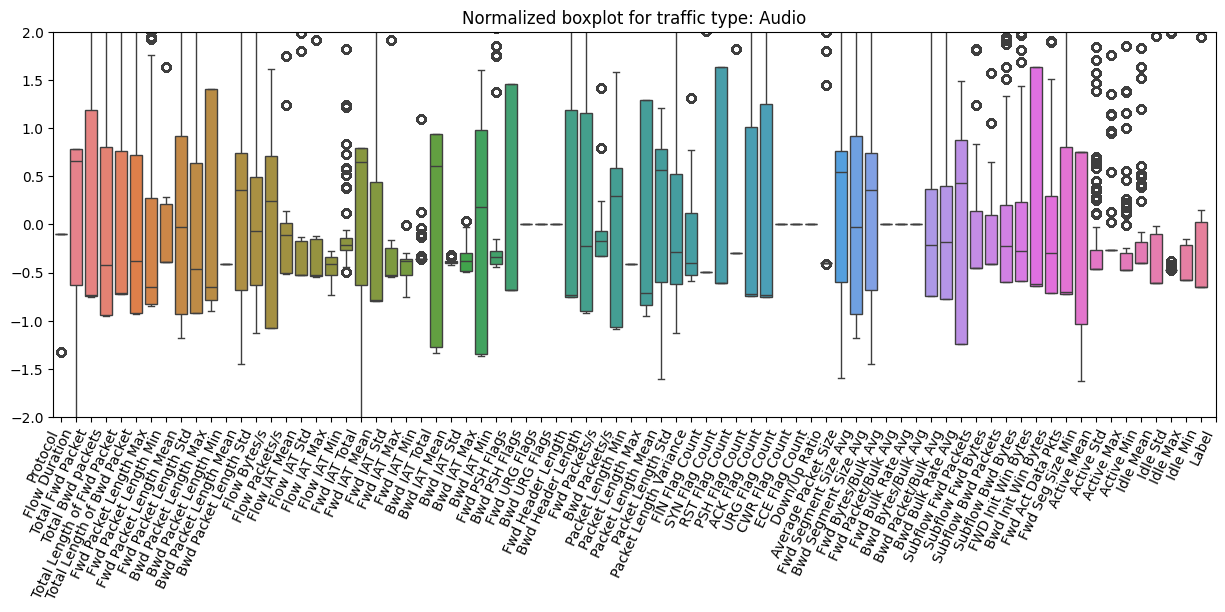

Generating boxplot ...


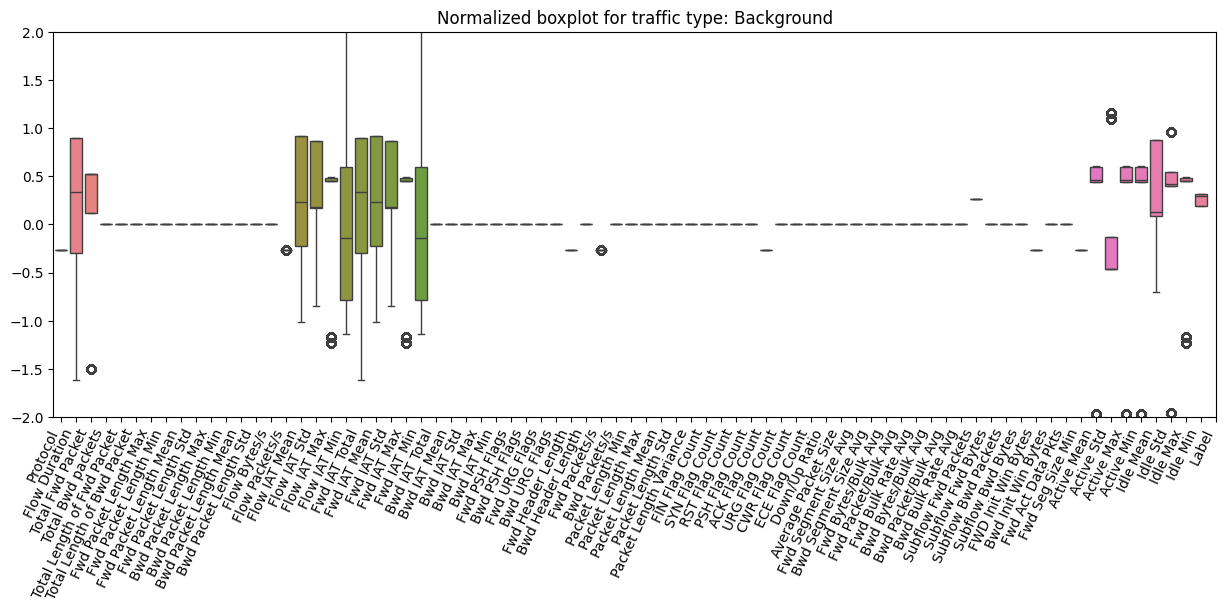

Generating boxplot ...


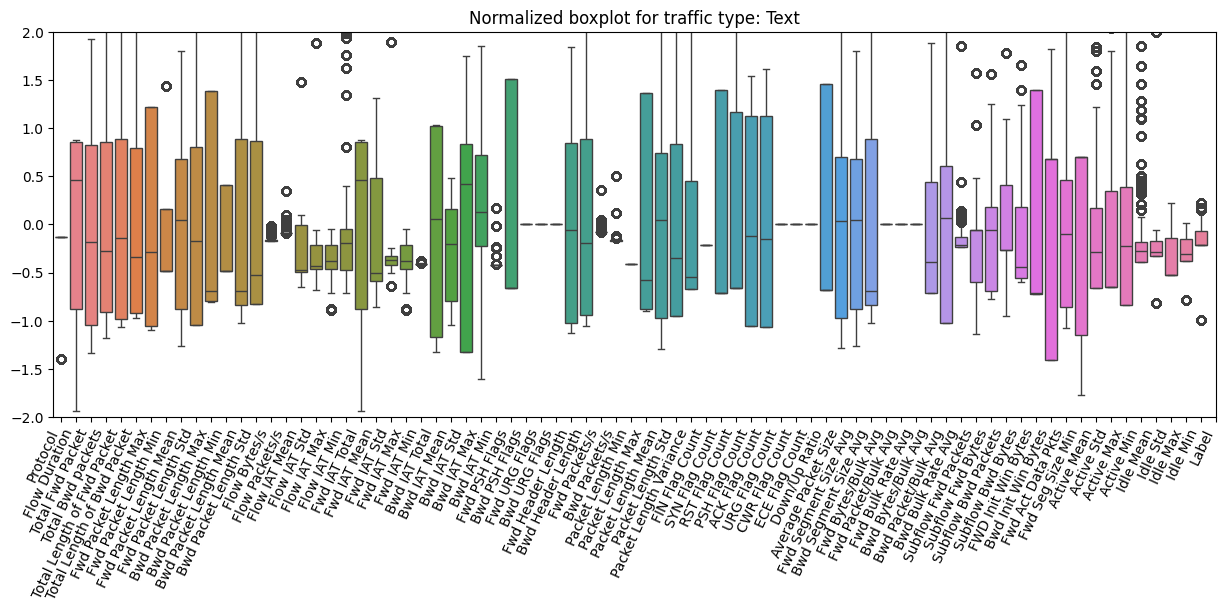

Generating boxplot ...


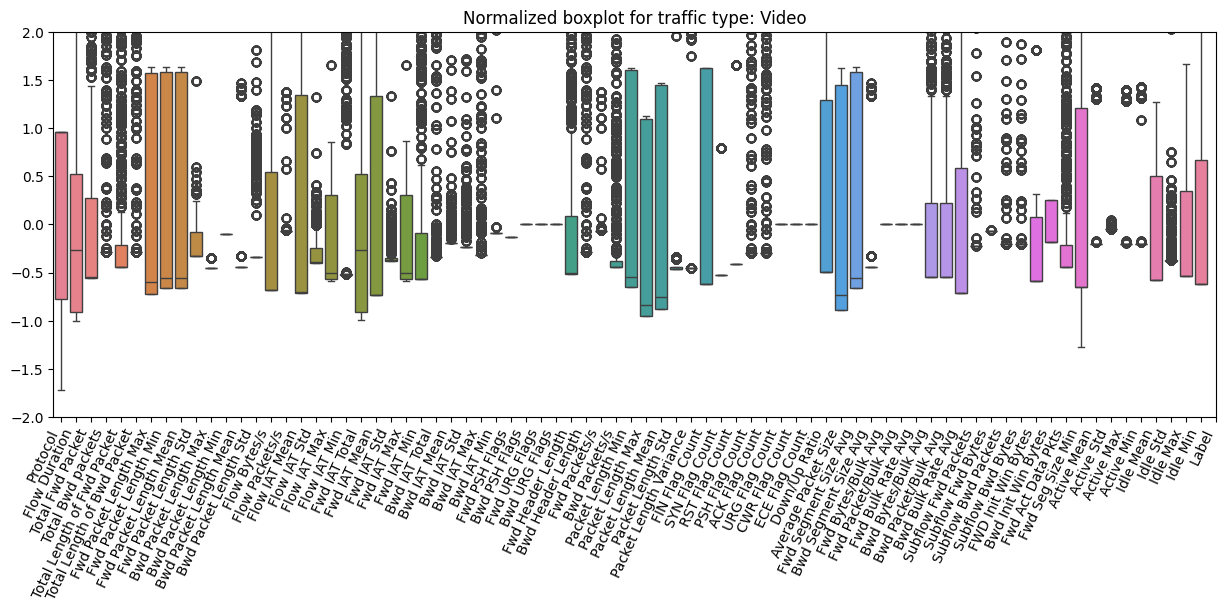

Generating boxplot ...


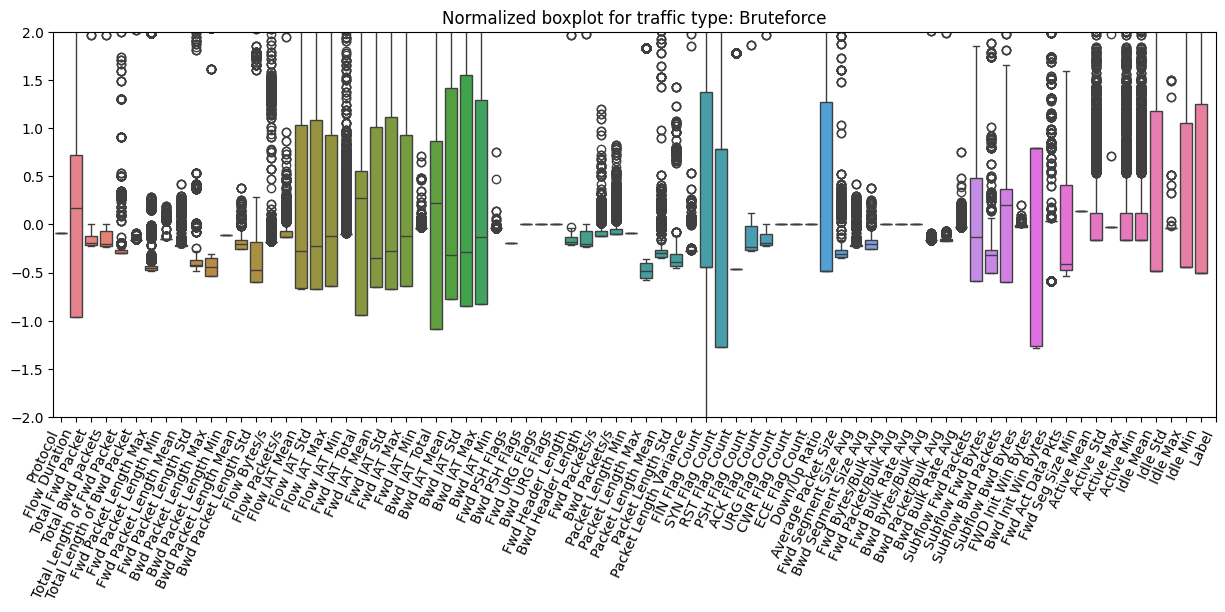

Generating boxplot ...


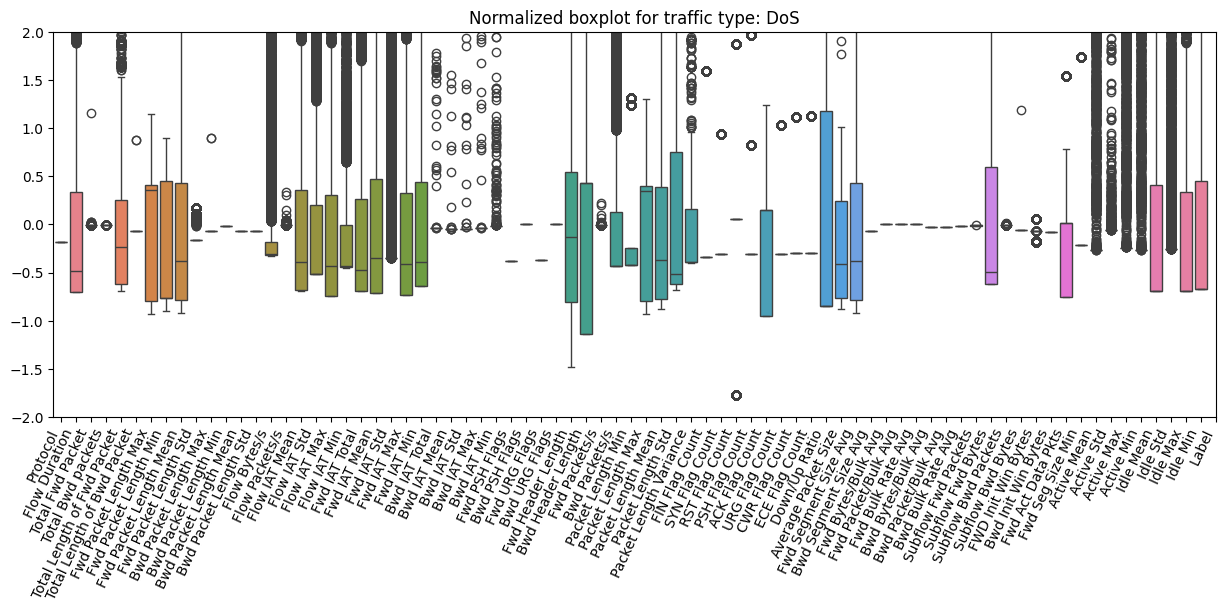

Generating boxplot ...


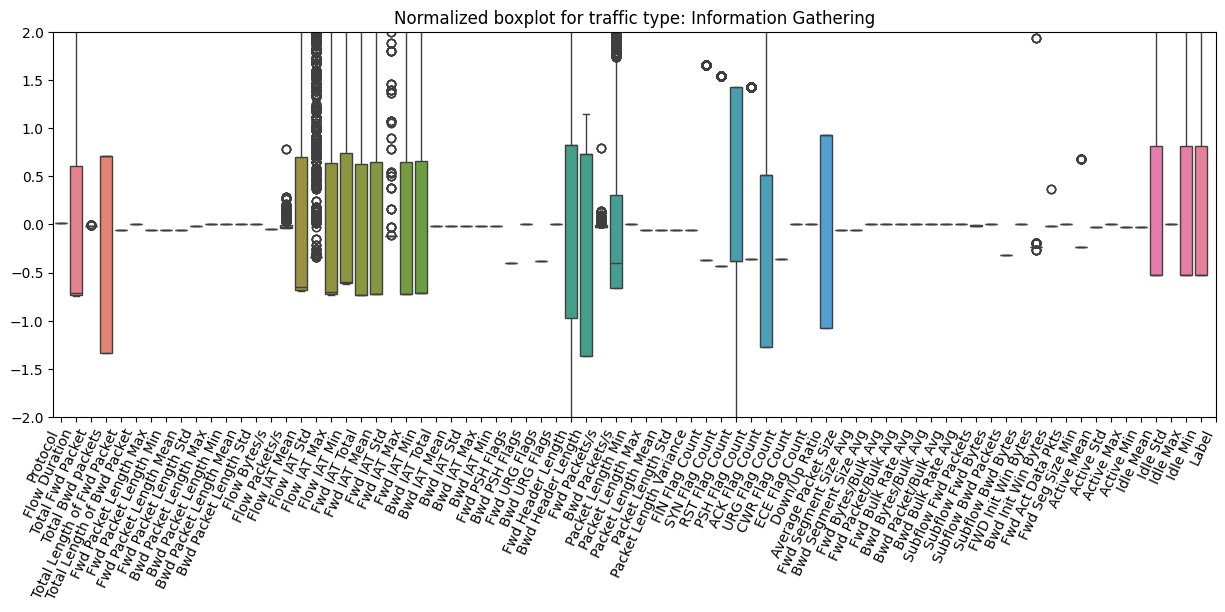

Generating boxplot ...


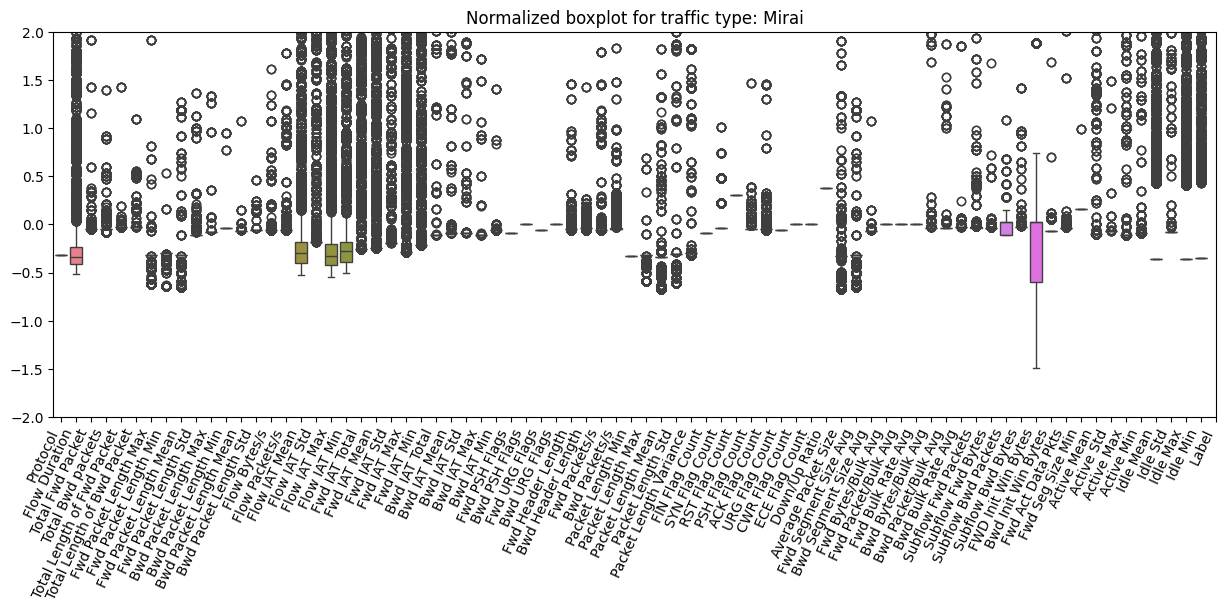

Generating boxplot ...


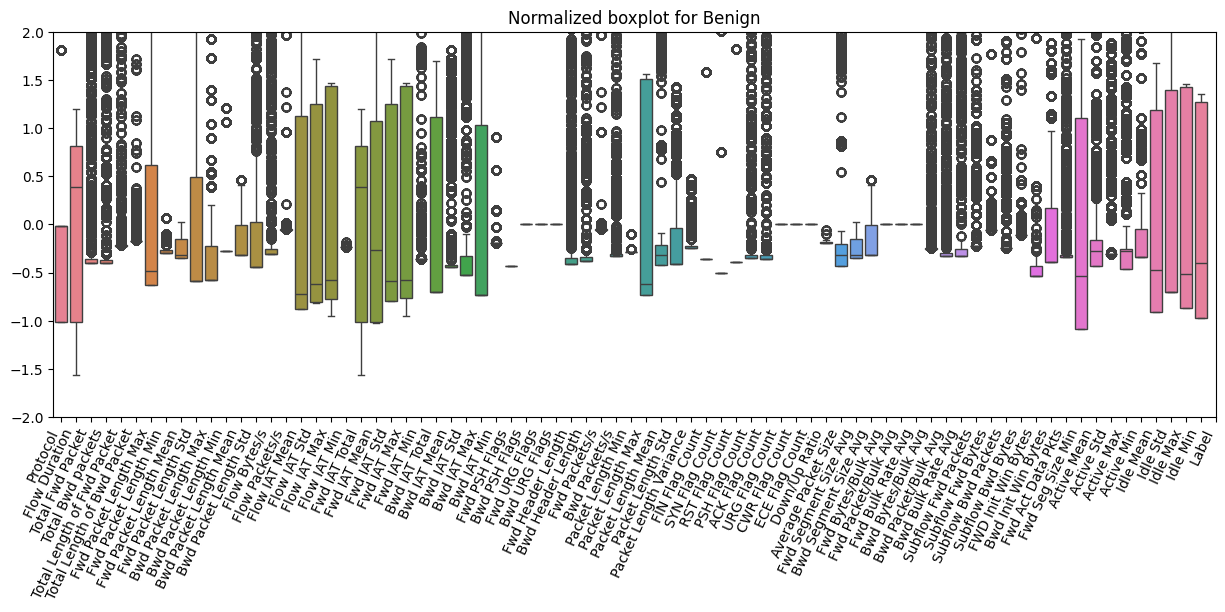

Generating boxplot ...


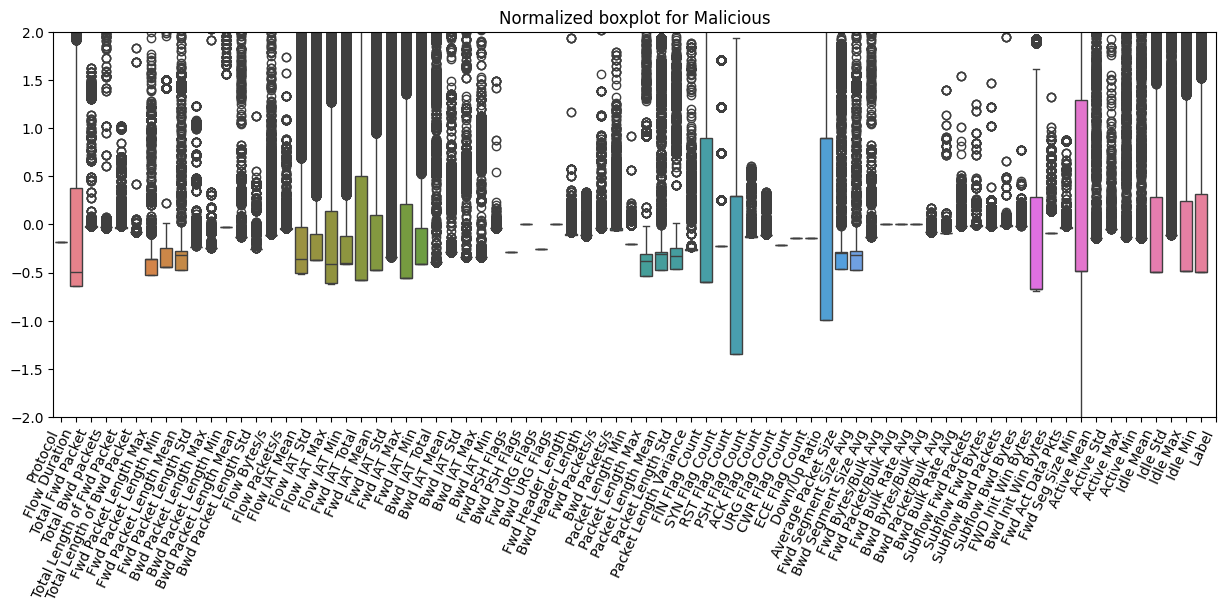

In [10]:
### PREPROCESSING (Implementation) - Present distributions for all metrics for both Benign and Malicious labels
ylim_top = 2
ylim_bot = -2
df_benign = df[df["Label"] == "Benign"].copy()
df_malicious = df[df["Label"] == "Malicious"].copy()

for ttype in ttype_list:
    boxplot(df[df["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), "Normalized boxplot for traffic type: " + ttype, ylim_bot, ylim_top, df.columns.tolist()[:-2])

boxplot(df_benign.drop(columns=TARGET_LABELS), "Normalized boxplot for Benign", ylim_bot, ylim_top, df.columns.tolist()[:-2])
boxplot(df_malicious.drop(columns=TARGET_LABELS), "Normalized boxplot for Malicious", ylim_bot, ylim_top, df.columns.tolist()[:-2])

In [168]:
# PREPROCESSING (Implementation) - Convert all data to numerical and compute correlations
df_num = labels_to_numerical(df, LABEL_MAPPER)
df_num = ttypes_to_numerical(df_num, TYPES_MAPPER)
df_num = subtypes_to_numerical(df_num, SUBTYPES_MAPPER)

cor = correlation(df_num, target = "Label", with_target=False)
cor_label, important_metrics_label = correlation(df_num, target = "Label", with_target=True)
cor_ttype, important_metrics_ttype = correlation(df_num, target = "Traffic Type", with_target=True)

label_barplot = important_metrics_label.copy()
label_barplot.remove("Traffic Type")
label_barplot.remove("Traffic Subtype")
ttype_barplot = important_metrics_ttype.copy()
ttype_barplot.remove("Label")
ttype_barplot.remove("Traffic Subtype")

21 Metrics with high correlation with Label
24 Metrics with high correlation with Label


Generating heatmap ...


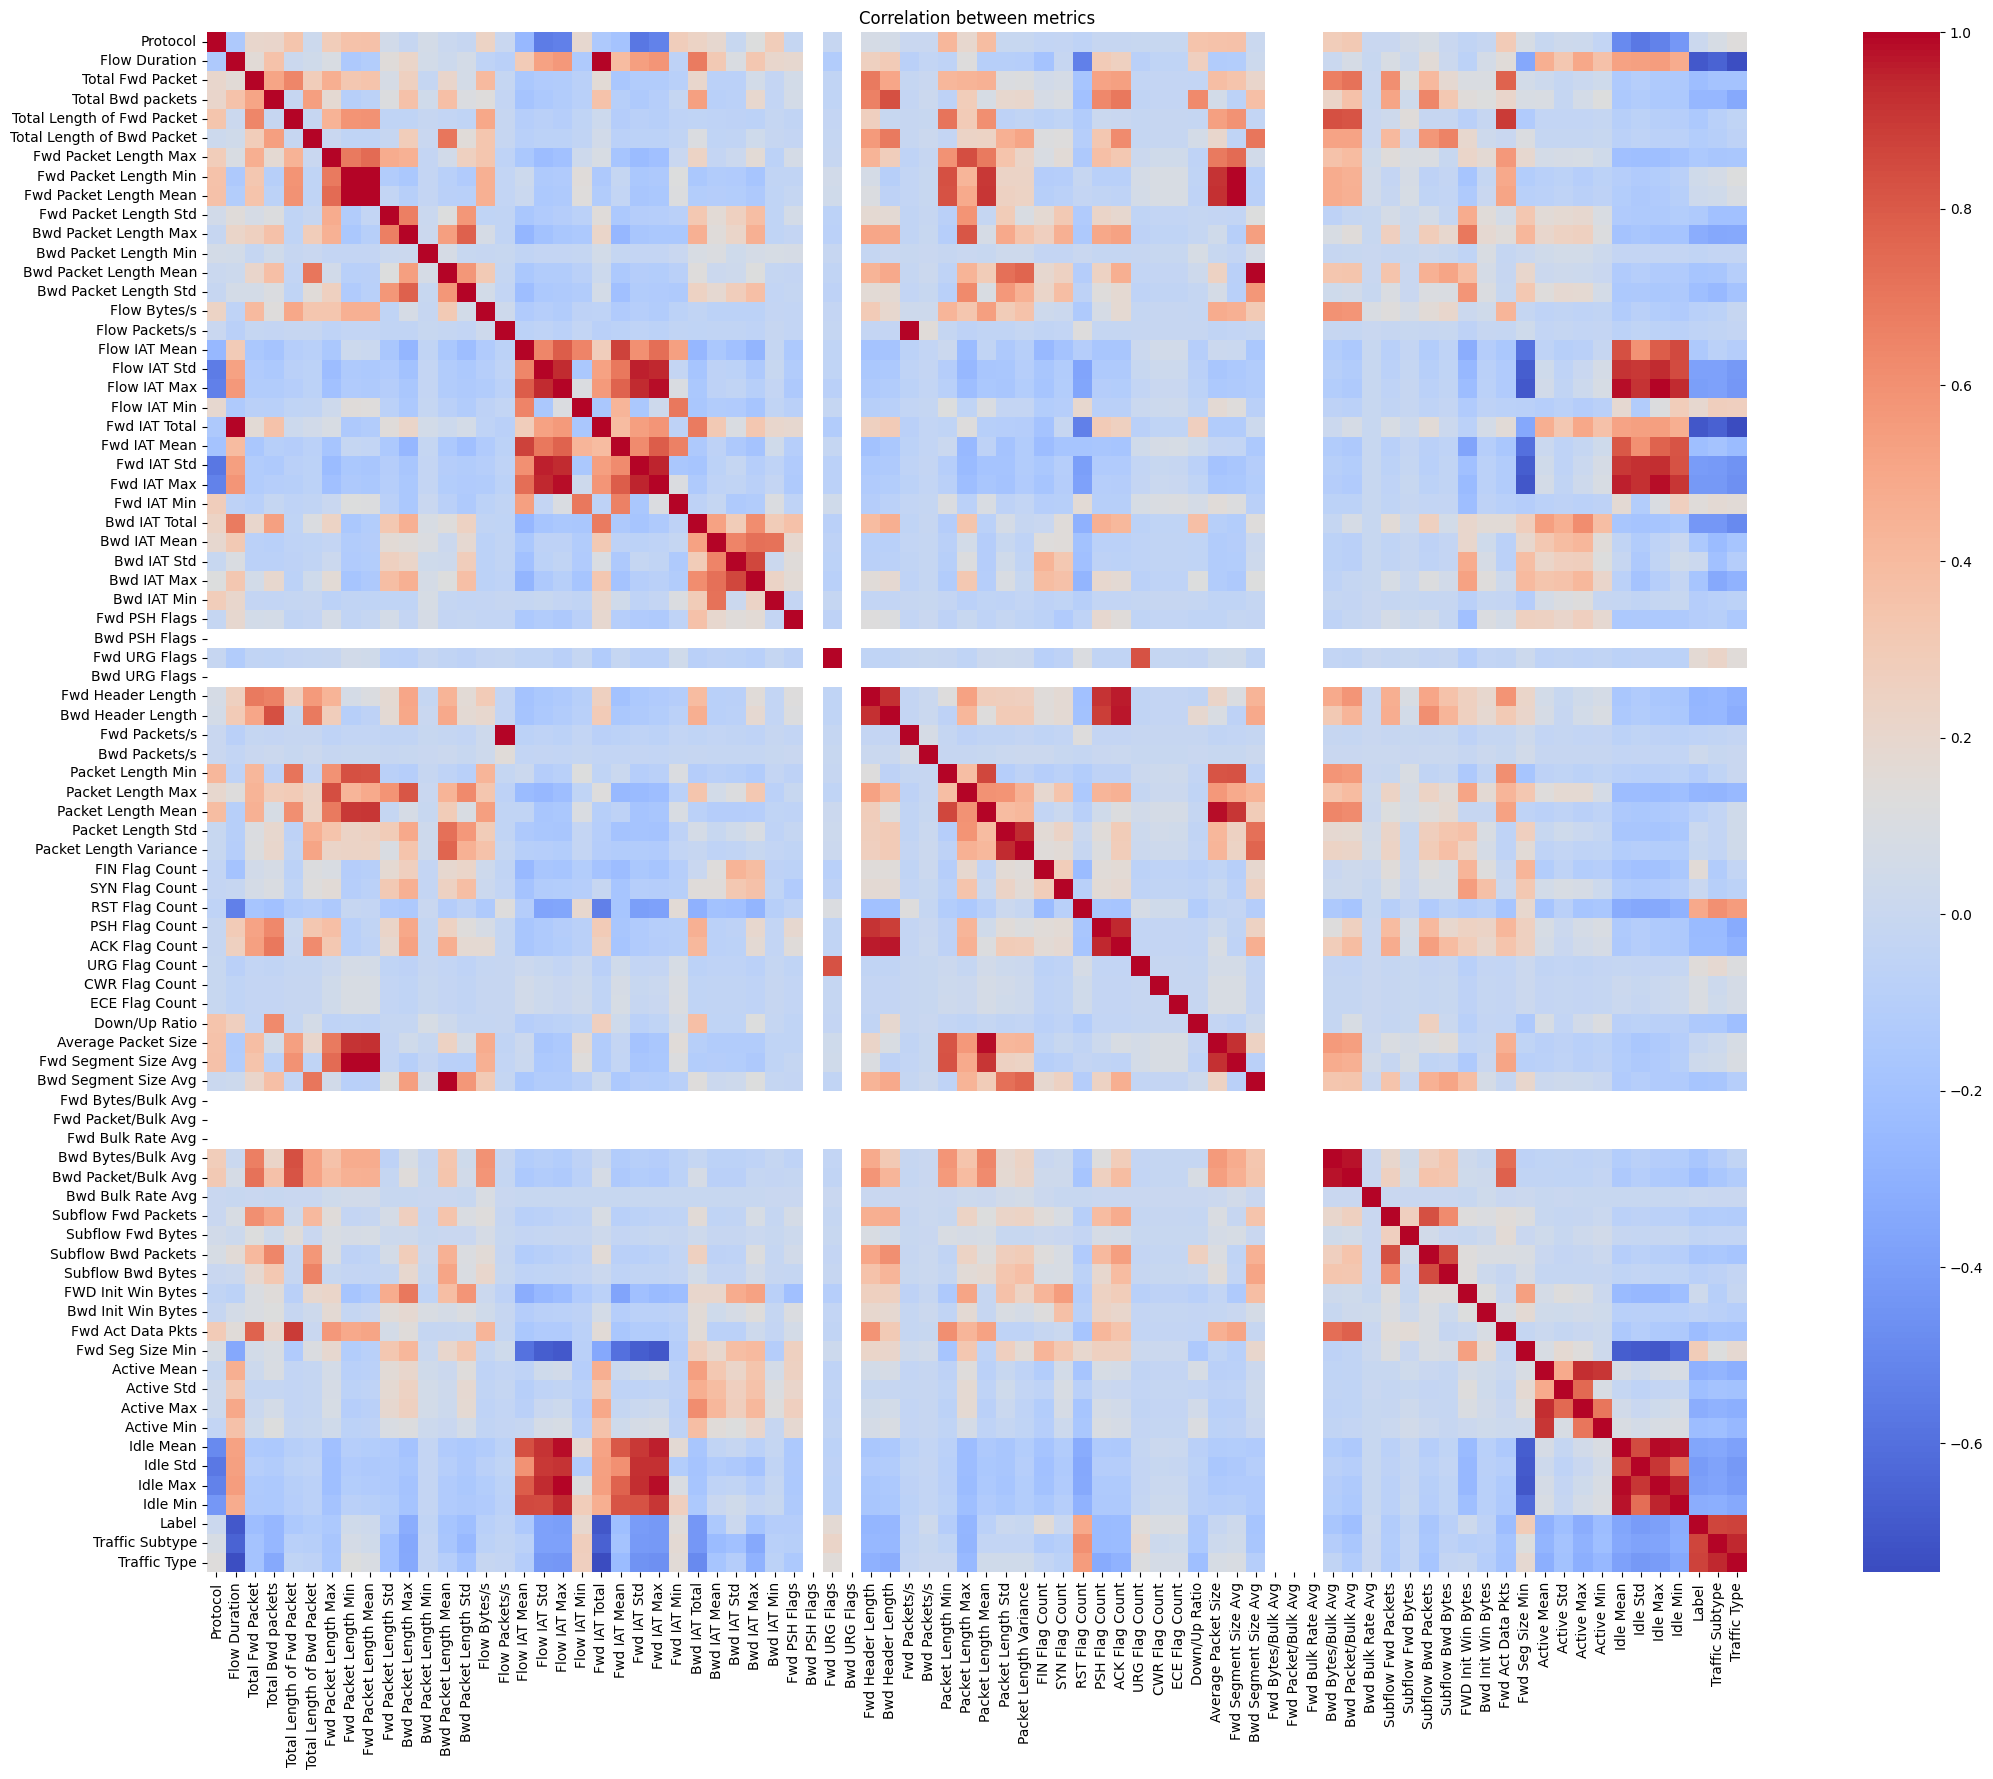

Generating heatmap ...


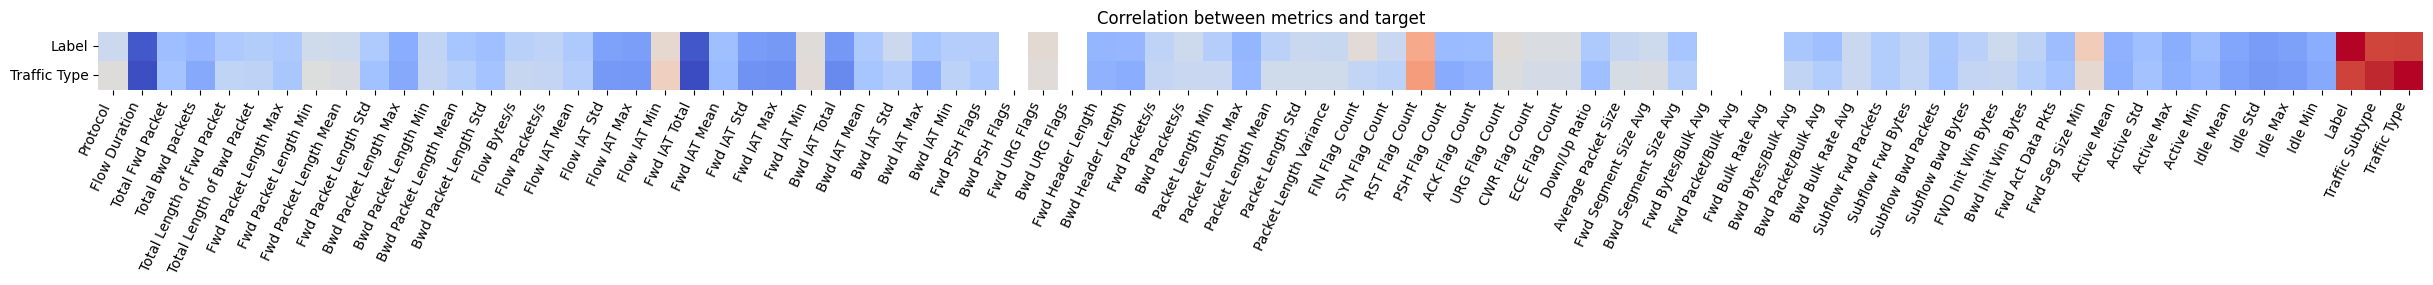

In [169]:
### PREPROCESSING (Implementation) - Create heatmaps
general_correlation = {"Correlation": cor}
heatmap(general_correlation, "Correlation between metrics")

targeted_correlation = {"Label": cor_label, "Traffic Type": cor_ttype}
heatmap(targeted_correlation, "Correlation between metrics and target", with_target=True)

Generating barplot ...


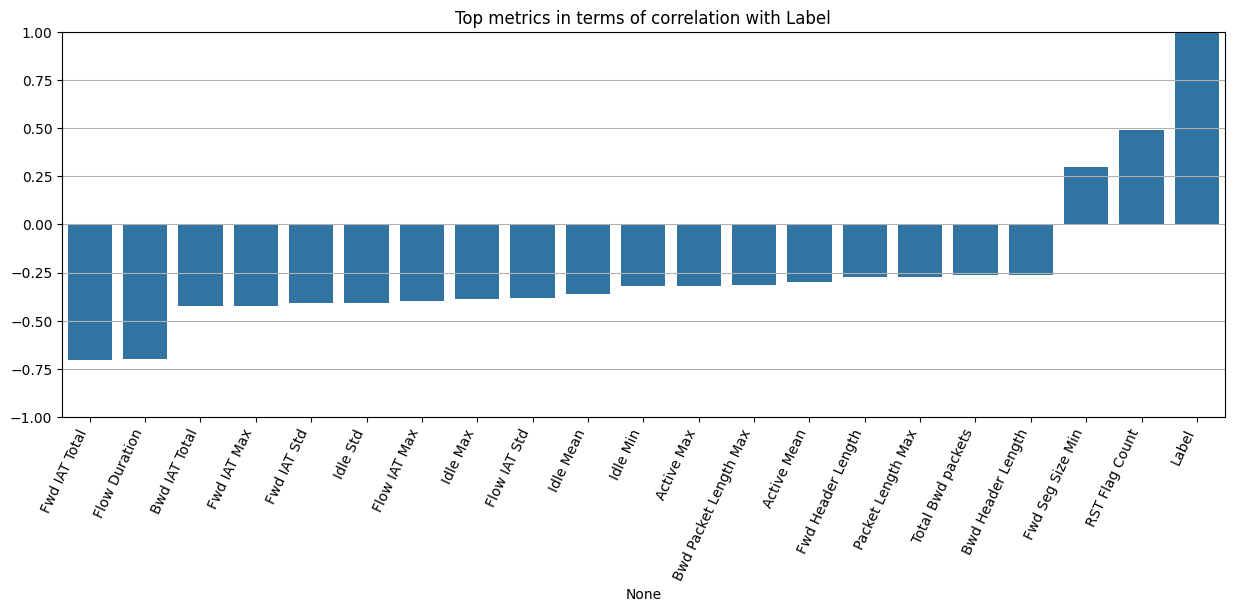

Generating barplot ...


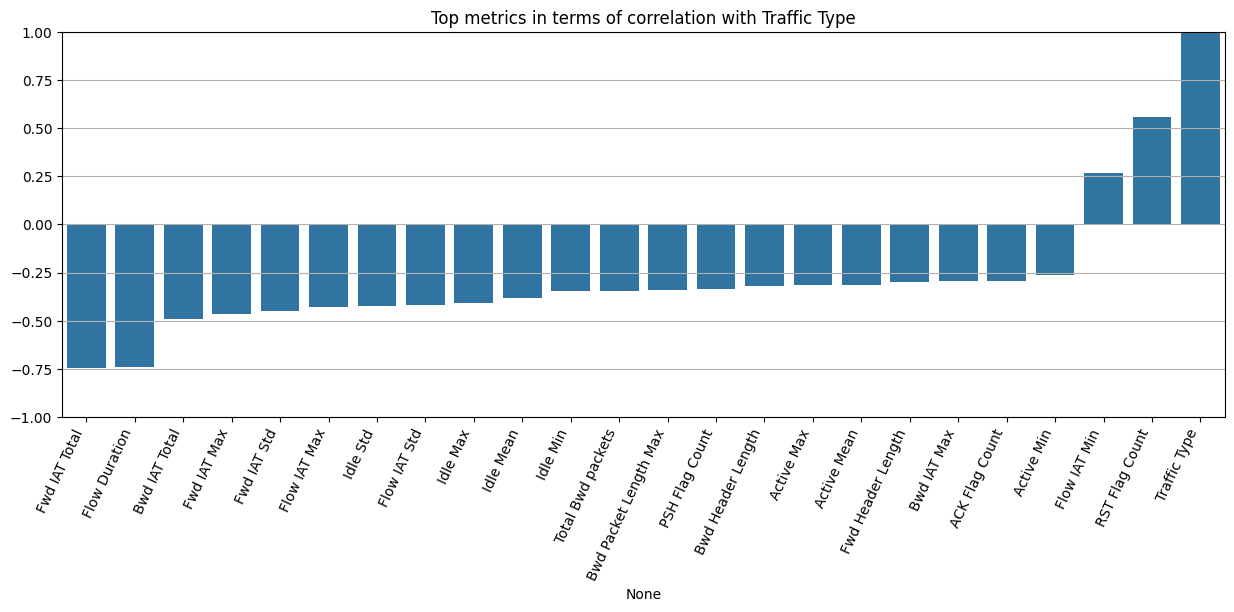

In [170]:
### PREPROCESSING (Implementation) - Showcase top correlations
df_important_metrics_label_count = cor_label.filter(items=label_barplot, axis="index").filter(["Label"]).sort_values(by="Label")
barplot(
    df_important_metrics_label_count.index, df_important_metrics_label_count.values.reshape(len(df_important_metrics_label_count.index)),
    "Top metrics in terms of correlation with Label"
)

df_important_metrics_ttype_count = cor_ttype.filter(items=ttype_barplot, axis="index").filter(["Traffic Type"]).sort_values(by="Traffic Type")
barplot(
    df_important_metrics_ttype_count.index, df_important_metrics_ttype_count.values.reshape(len(df_important_metrics_ttype_count.index)),
    "Top metrics in terms of correlation with Traffic Type"
)

In [172]:
### PREPROCESSING (Implementation) - DataFrames with metrics highly correlated with targets, dimension reduction
DIM_TARGET1 = 8
DIM_TARGET2 = 8
df_label = df_num[important_metrics_label].copy()
df_ttype = df_num[important_metrics_ttype].copy()

print("Target Label:")
df_labelDimReduction = dim_reduction(df_label.drop(columns=TARGET_LABELS), DIM_TARGET1, "PCA")
df_labelDimReduction["Label"] = df_label["Label"]
df_labelDimReduction["Traffic Type"] = df_label["Traffic Type"]
df_labelDimReduction["Traffic Subtype"] = df_label["Traffic Subtype"]
print("Target Traffic Type:")
df_ttypeDimReduction = dim_reduction(df_ttype.drop(columns=TARGET_LABELS), DIM_TARGET2, "PCA")
df_ttypeDimReduction["Label"] = df_ttype["Label"]
df_ttypeDimReduction["Traffic Type"] = df_ttype["Traffic Type"]
df_ttypeDimReduction["Traffic Subtype"] = df_ttype["Traffic Subtype"]


Target Label:
PCA METHOD --> Cumulative variance: 0.9650974041282337
Target Traffic Type:
PCA METHOD --> Cumulative variance: 0.9564027426218633


In [173]:
### PREPROCESSING (Implementation) - Sampling, Clustering with BIRCH, Clustering with HDBSCAN
# Data reduction through sampling
df_label_sampling = sampling(df_labelDimReduction, 0.3, notext=True)
df_ttype_sampling = sampling(df_ttypeDimReduction, 0.3, notext=True)

# Data reduction through BIRCH clustering
print("\nBIRCH with target: Label")
df_label_BIRCH, BIRCH_model_label = BIRCH_clustering(df_labelDimReduction.drop(columns=TARGET_LABELS), 2500, threshold=0.1)
df_label_BIRCH["Label"] = df_labelDimReduction["Label"]
df_label_BIRCH["Traffic Type"] = df_labelDimReduction["Traffic Type"]
print("\nBIRCH with target: Traffic Type")
df_ttype_BIRCH, BIRCH_model_ttype = BIRCH_clustering(df_ttypeDimReduction.drop(columns=TARGET_LABELS), 8000, threshold=0.01)
df_ttype_BIRCH["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]
df_ttype_BIRCH["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]

# Data reduction through HDBSCAN clustering
print("\nHDBSCAN with target: Label")
df_label_HDBSCAN, HDBSCAN_model_label = HDBSCAN_clustering(df_labelDimReduction.drop(columns=TARGET_LABELS), 100)
df_label_HDBSCAN["Label"] = df_labelDimReduction["Label"]
df_label_HDBSCAN["Traffic Type"] = df_labelDimReduction["Traffic Type"]
print("\nHDBSCAN with target: Traffic Type")
df_ttype_HDBSCAN, HDBSCAN_model_ttype = HDBSCAN_clustering(df_ttypeDimReduction.drop(columns=TARGET_LABELS), 10)
df_ttype_HDBSCAN["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]
df_ttype_HDBSCAN["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]


BIRCH with target: Label
2486 Clusters
Davies-Bouldin Index: 0.03390827897303879

BIRCH with target: Traffic Type


c:\Users\sgdim\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (6999) by BIRCH is less than (8000). Decrease the threshold.
  warnings.warn(


6376 Clusters
Davies-Bouldin Index: 0.005230836976718362

HDBSCAN with target: Label
456 Clusters
Davies-Bouldin Index: 0.0670429281805509

HDBSCAN with target: Traffic Type
3417 Clusters
Davies-Bouldin Index: 0.02023488320150797


BIRCH, target = Label:
Problematic Cluster - Ratio: 0.322%
Population that belongs to Problematic Clusters - Ratio: 9.135%
Clusters assigned to each Label: {0: 312, 1: 2160}
Problematic Clusters assigned to each Label: {0: 6, 1: 2}
Total Clusters: 2486
Empty clusters: 14
Total Population predicted per Target: {0: 77851, 1: 82084}
Real Population per Target: {0: 80002, 1: 80152}


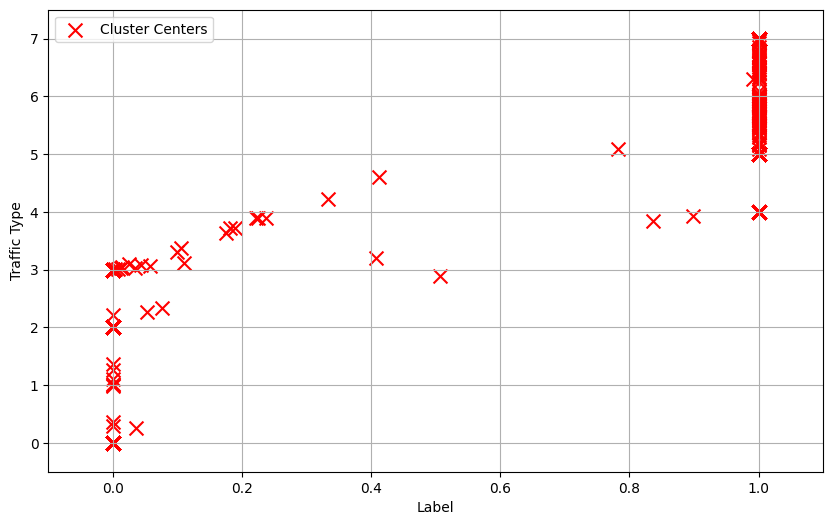

BIRCH, target = Traffic Type:
Problematic Cluster - Ratio: 4.062%
Population that belongs to Problematic Clusters - Ratio: 38.067%
Clusters assigned to each Traffic Type: {0: 78, 1: 6, 2: 92, 3: 302, 4: 494, 5: 4236, 6: 319, 7: 292}
Problematic Clusters assigned to each Traffic Type: {0: 2, 1: 3, 2: 2, 3: 2, 4: 2, 5: 80, 6: 125, 7: 43}
Total Clusters: 6376
Empty clusters: 557
Total Population predicted per Target: {0: 13779, 1: 23482, 2: 17247, 3: 14547, 4: 18379, 5: 10420, 6: 32784, 7: 19032}
Real Population per Target: {0: 20007, 1: 20009, 2: 19968, 3: 20018, 4: 20101, 5: 20062, 6: 19937, 7: 20052}


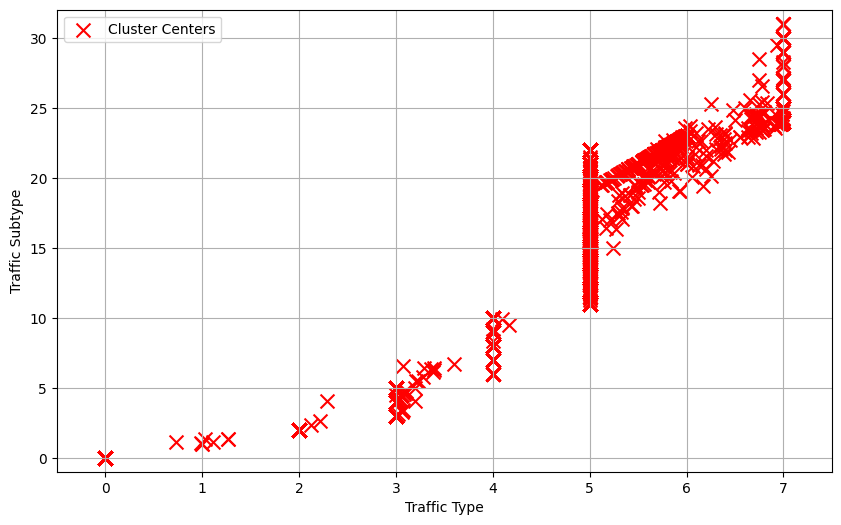

HDBSCAN, target = Traffic Type:
Problematic Cluster - Ratio: 0.438%
Population that belongs to Problematic Clusters - Ratio: 0.356%
Clusters assigned to each Label: {0: 338, 1: 118}
Problematic Clusters assigned to each Label: {0: 2, 1: 0}
Total Clusters: 457
Empty clusters: 1
Total Population predicted per Target: {0: 77894, 1: 64127}
Real Population per Target: {0: 80002, 1: 80152}


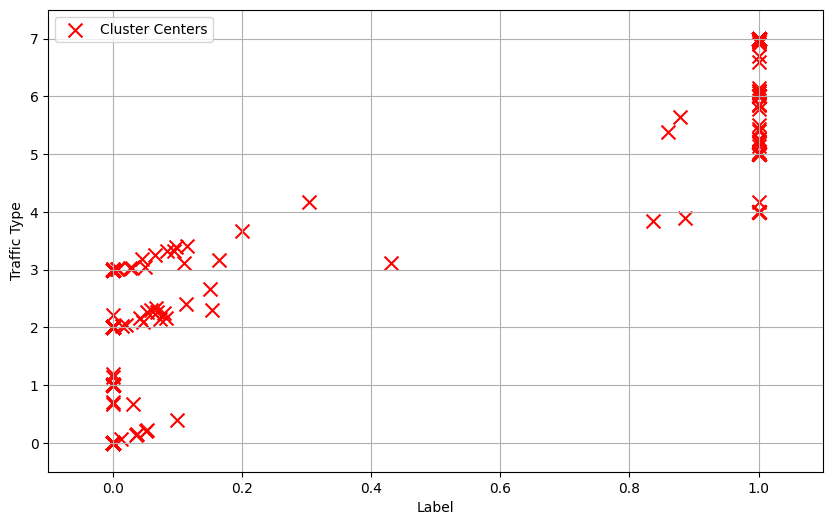

HDBSCAN, target = Traffic Type:
Problematic Cluster - Ratio: 26.770%
Population that belongs to Problematic Clusters - Ratio: 12.372%
Clusters assigned to each Traffic Type: {0: 125, 1: 25, 2: 135, 3: 548, 4: 315, 5: 327, 6: 998, 7: 944}
Problematic Clusters assigned to each Traffic Type: {0: 0, 1: 0, 2: 0, 3: 17, 4: 1, 5: 196, 6: 583, 7: 118}
Total Clusters: 3418
Empty clusters: 1
Total Population predicted per Target: {0: 20067, 1: 20009, 2: 20058, 3: 20311, 4: 13198, 5: 8366, 6: 20424, 7: 17871}
Real Population per Target: {0: 20007, 1: 20009, 2: 19968, 3: 20018, 4: 20101, 5: 20062, 6: 19937, 7: 20052}


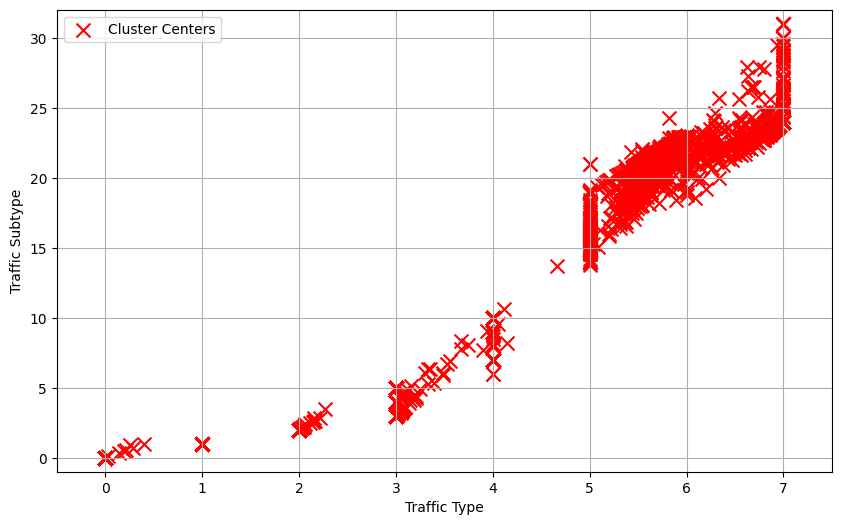

In [174]:
### PREPROCESSING (Implementation) - Visualize clusters and discard problematic ones

print("BIRCH, target = Label:")
df_label_BIRCH_cleaned = evaluate_clusters(df_label_BIRCH, "Label", "Traffic Type", 2)
print("BIRCH, target = Traffic Type:")
df_ttype_BIRCH_cleaned = evaluate_clusters(df_ttype_BIRCH, "Traffic Type", "Traffic Subtype", 8, cluster_ratio_cap=0.15)

print("HDBSCAN, target = Traffic Type:")
df_label_HDBSCAN_cleaned = evaluate_clusters(df_label_HDBSCAN, "Label", "Traffic Type", 2)
print("HDBSCAN, target = Traffic Type:")
df_ttype_HDBSCAN_cleaned = evaluate_clusters(df_ttype_HDBSCAN, "Traffic Type", "Traffic Subtype", 8, cluster_ratio_cap=0.15)

In [176]:
### PREPROCESSING (Implementation) - Produce samples for testing
testing_num = labels_to_numerical(df_test, LABEL_MAPPER)
testing_num = ttypes_to_numerical(testing_num, TYPES_MAPPER)
testing_num = subtypes_to_numerical(testing_num, SUBTYPES_MAPPER).sample(frac=1, ignore_index=True)

testing_label = dim_reduction(testing_num[important_metrics_label].drop(columns=TARGET_LABELS), DIM_TARGET1, "PCA", notext=True)
testing_label["Label"] = testing_num["Label"]

testing_ttype = dim_reduction(testing_num[important_metrics_ttype].drop(columns=TARGET_LABELS), DIM_TARGET2, "PCA", notext=True)
testing_ttype["Traffic Type"] = testing_num["Traffic Type"]

In [177]:
### PREPROCESSING (Implementation) - Produce samples for training
# Sampling data
training_sampled_label = df_label_sampling.drop(columns=["Traffic Type", "Traffic Subtype"])
print("Sampling method for Label: {0} samples".format(len(training_sampled_label)))
training_sampled_ttype = df_ttype_sampling.drop(columns=["Label", "Traffic Subtype"])
print("Sampling method for Traffic Type: {0} samples".format(len(training_sampled_ttype)))

# BIRCH datadf_label_BIRCH
training_BIRCH_label = format_data(df_label_BIRCH_cleaned.drop(columns=["Traffic Type"]), "Label", 2)
print("Sampling method for Label: {0} samples".format(len(training_BIRCH_label)))
training_BIRCH_ttype = format_data(df_ttype_BIRCH_cleaned.drop(columns=["Traffic Subtype"]), "Traffic Type", 8)
print("Sampling method for Traffic Type: {0} samples".format(len(training_BIRCH_ttype)))

# HDBSCAN data
training_HDBSCAN_label = format_data(df_label_HDBSCAN_cleaned.drop(columns=["Traffic Type"]), "Label", 2)
print("Sampling method for Label: {0} samples".format(len(training_HDBSCAN_label)))
training_HDBSCAN_ttype = format_data(df_ttype_HDBSCAN_cleaned.drop(columns=["Traffic Subtype"]), "Traffic Type", 8)
print("Sampling method for Traffic Type: {0} samples".format(len(training_HDBSCAN_ttype)))

Sampling method for Label: 48046 samples
Sampling method for Traffic Type: 48046 samples
Sampling method for Label: 4362 samples
Sampling method for Traffic Type: 39714 samples
Sampling method for Label: 642 samples
Sampling method for Traffic Type: 9578 samples


In [178]:
### TRAINING/TESTING (Imports) - Import necessary libraries for training and testing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [179]:
### TRAINING/TESTING (Function definitions) - Dataloader
def generate_dataloader(df_train: pd.DataFrame, df_test: pd.DataFrame, target: str, batch_size=32) -> DataLoader:
    y_train = df_train[target]
    x_train = df_train.drop(columns=[target])
    y_test = df_test[target]
    x_test = df_test.drop(columns=[target])

    x_train_tensor = torch.tensor(np.array(x_train), dtype=torch.float32)
    x_test_tensor = torch.tensor(np.array(x_test), dtype=torch.float32)
    y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long)
    y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    training_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testing_data = DataLoader(test_dataset, batch_size=batch_size)

    return training_data, testing_data

In [195]:
### TRAINING/TESTING (Class/Functions definitions) - Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

def NeuralNetworkClassification(df_train: pd.DataFrame, df_test: pd.DataFrame, target, batch_size=32, epochs=50, lr=0.005) -> None:

    # Generate dataloader
    train_data_sampling, test_data_sampling = generate_dataloader(df_train, df_test, target, batch_size=batch_size)

    input_dim = df_train.shape[1] - 1
    if target == 'Label': 
        output_dim = 2
        labels = ["Benign", "Malicious"]
    elif target == 'Traffic Type': 
        output_dim = 8
        labels = ["Audio", "Background", "Text", "Video", "Bruteforce", "DoS", "Information Gathering", "Mirai"]

    # Neural Network model, loss functions and optimizer
    model = NeuralNetwork(input_dim, output_dim)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_data_sampling:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_function(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if epoch % 10 == 0: print(f"Epoch {epoch}/{epochs} -> Loss: {total_loss:.4f}")

    # Testing
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_data_sampling:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    # Accuracy and classification report
    print(f"Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    confusion_matrix_nn = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix_nn, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

Epoch 0/70 -> Loss: 27.1287
Epoch 10/70 -> Loss: 13.1654
Epoch 20/70 -> Loss: 9.6653
Epoch 30/70 -> Loss: 7.8413
Epoch 40/70 -> Loss: 6.9027
Epoch 50/70 -> Loss: 6.3628
Epoch 60/70 -> Loss: 6.0185
Test Accuracy: 93.02%
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     50172
           1       0.89      0.98      0.93     50172

    accuracy                           0.93    100344
   macro avg       0.93      0.93      0.93    100344
weighted avg       0.93      0.93      0.93    100344



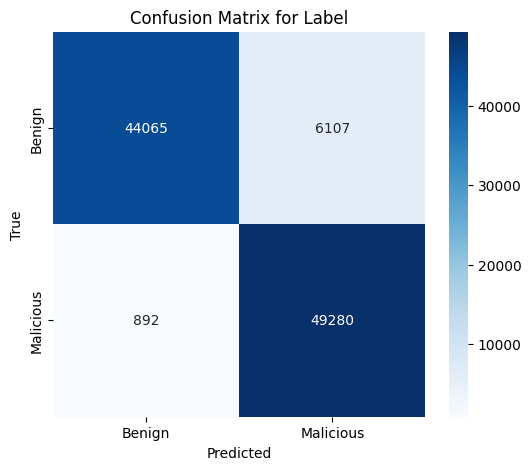

In [197]:
# Neural Network LABEL classification on the sampling-based dataset

NeuralNetworkClassification(training_sampled_label, testing_label, 'Label', batch_size=1024, lr=1e-4, epochs=70)

Epoch 0/100 -> Loss: 25.3379
Epoch 10/100 -> Loss: 3.7515
Epoch 20/100 -> Loss: 2.5346
Epoch 30/100 -> Loss: 1.6653
Epoch 40/100 -> Loss: 1.4557
Epoch 50/100 -> Loss: 1.2562
Epoch 60/100 -> Loss: 1.1858
Epoch 70/100 -> Loss: 1.1343
Epoch 80/100 -> Loss: 1.1497
Epoch 90/100 -> Loss: 1.0743
Test Accuracy: 90.41%
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     50172
           1       0.89      0.92      0.91     50172

    accuracy                           0.90    100344
   macro avg       0.90      0.90      0.90    100344
weighted avg       0.90      0.90      0.90    100344



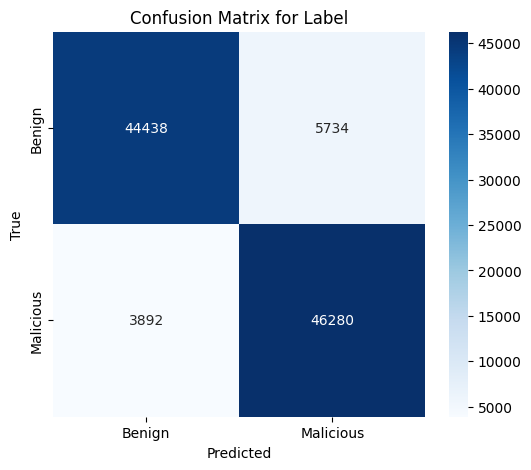

In [199]:
# Neural Network LABEL classification on the BIRCH-based dataset

NeuralNetworkClassification(training_BIRCH_label, testing_label, 'Label', batch_size=64, epochs=100, lr=1e-3)

Epoch 0/400 -> Loss: 20.1073
Epoch 10/400 -> Loss: 7.8999
Epoch 20/400 -> Loss: 6.2388
Epoch 30/400 -> Loss: 5.5446
Epoch 40/400 -> Loss: 4.9618
Epoch 50/400 -> Loss: 5.0221
Epoch 60/400 -> Loss: 4.6246
Epoch 70/400 -> Loss: 4.3115
Epoch 80/400 -> Loss: 4.1152
Epoch 90/400 -> Loss: 4.1121
Epoch 100/400 -> Loss: 3.8813
Epoch 110/400 -> Loss: 3.7646
Epoch 120/400 -> Loss: 3.7594
Epoch 130/400 -> Loss: 3.6365
Epoch 140/400 -> Loss: 3.5301
Epoch 150/400 -> Loss: 3.4595
Epoch 160/400 -> Loss: 3.3380
Epoch 170/400 -> Loss: 3.4536
Epoch 180/400 -> Loss: 3.7518
Epoch 190/400 -> Loss: 3.4240
Epoch 200/400 -> Loss: 3.4470
Epoch 210/400 -> Loss: 3.2790
Epoch 220/400 -> Loss: 3.3279
Epoch 230/400 -> Loss: 3.4943
Epoch 240/400 -> Loss: 4.0386
Epoch 250/400 -> Loss: 3.3657
Epoch 260/400 -> Loss: 3.1205
Epoch 270/400 -> Loss: 3.0597
Epoch 280/400 -> Loss: 3.2475
Epoch 290/400 -> Loss: 3.1232
Epoch 300/400 -> Loss: 2.9619
Epoch 310/400 -> Loss: 3.1732
Epoch 320/400 -> Loss: 3.3087
Epoch 330/400 -> Los

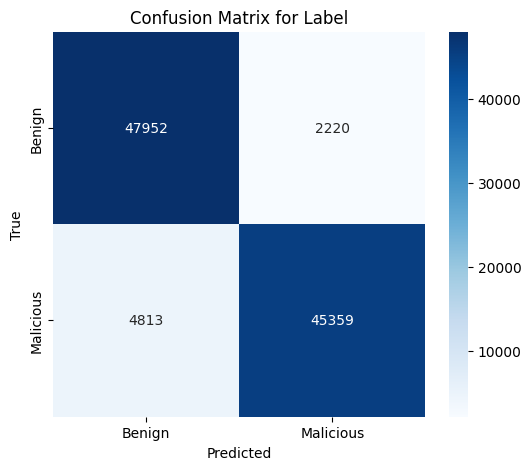

In [200]:
# Neural Network LABEL classification on the HDBSCAN-based dataset

NeuralNetworkClassification(training_HDBSCAN_label, testing_label, 'Label', batch_size=16, epochs=400, lr=5 * 1e-4)

Epoch 0/80 -> Loss: 12.0140
Epoch 10/80 -> Loss: 7.1403
Epoch 20/80 -> Loss: 6.1834
Epoch 30/80 -> Loss: 5.5787
Epoch 40/80 -> Loss: 5.0778
Epoch 50/80 -> Loss: 4.7220
Epoch 60/80 -> Loss: 4.4691
Epoch 70/80 -> Loss: 4.2947
Test Accuracy: 61.36%
              precision    recall  f1-score   support

           0       0.76      0.51      0.61     12543
           1       0.65      0.86      0.74     12543
           2       0.63      0.78      0.70     12543
           3       0.84      0.45      0.58     12543
           4       0.47      0.40      0.43     12543
           5       0.65      0.33      0.43     12543
           6       0.46      0.67      0.54     12543
           7       0.64      0.92      0.76     12543

    accuracy                           0.61    100344
   macro avg       0.64      0.61      0.60    100344
weighted avg       0.64      0.61      0.60    100344



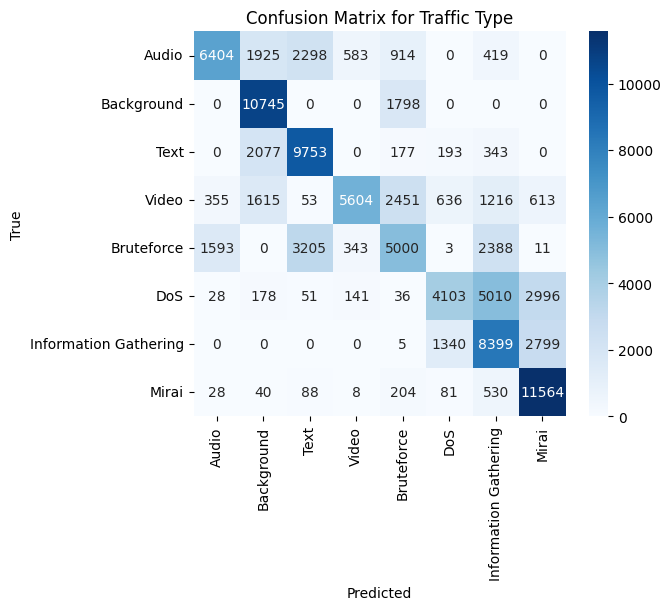

In [208]:
# Neural Network TRAFFIC TYPE classification on the Sample-based dataset

NeuralNetworkClassification(training_sampled_ttype, testing_ttype, 'Traffic Type', batch_size=8192, epochs=80, lr=1e-3)

Epoch 0/80 -> Loss: 19.6207
Epoch 10/80 -> Loss: 9.5904
Epoch 20/80 -> Loss: 7.9633
Epoch 30/80 -> Loss: 7.0264
Epoch 40/80 -> Loss: 6.2962
Epoch 50/80 -> Loss: 5.8097
Epoch 60/80 -> Loss: 5.5198
Epoch 70/80 -> Loss: 5.3114
Test Accuracy: 58.92%
              precision    recall  f1-score   support

           0       0.95      0.59      0.73     12543
           1       0.68      0.86      0.76     12543
           2       0.83      0.75      0.79     12543
           3       0.67      0.45      0.53     12543
           4       0.48      0.40      0.43     12543
           5       0.48      0.31      0.38     12543
           6       0.44      0.43      0.43     12543
           7       0.45      0.94      0.61     12543

    accuracy                           0.59    100344
   macro avg       0.62      0.59      0.58    100344
weighted avg       0.62      0.59      0.58    100344



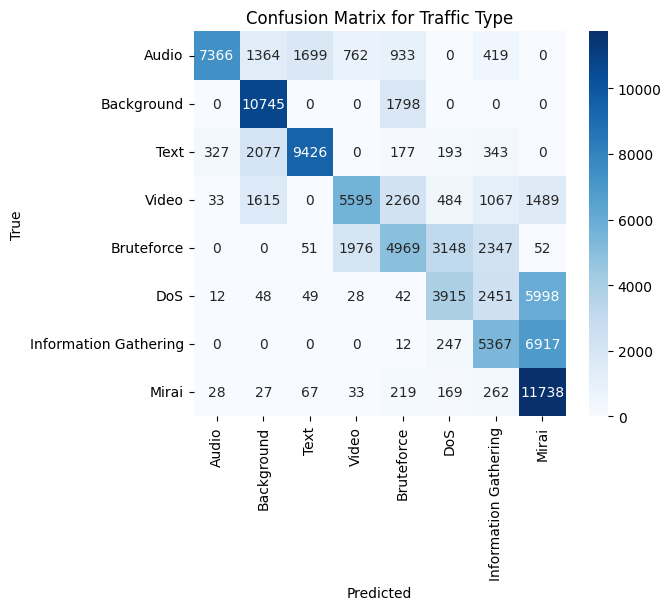

In [209]:
# Neural Network TRAFFIC TYPE classification on the Sample-based dataset

NeuralNetworkClassification(training_BIRCH_ttype, testing_ttype, 'Traffic Type', batch_size=4096, epochs=80, lr=1e-3)

Epoch 0/200 -> Loss: 12.4469
Epoch 10/200 -> Loss: 6.0567
Epoch 20/200 -> Loss: 5.9804
Epoch 30/200 -> Loss: 5.4771
Epoch 40/200 -> Loss: 5.6250
Epoch 50/200 -> Loss: 5.5592
Epoch 60/200 -> Loss: 5.5049
Epoch 70/200 -> Loss: 5.6731
Epoch 80/200 -> Loss: 5.4536
Epoch 90/200 -> Loss: 5.5812
Epoch 100/200 -> Loss: 5.7703
Epoch 110/200 -> Loss: 5.3941
Epoch 120/200 -> Loss: 5.5956
Epoch 130/200 -> Loss: 5.4859
Epoch 140/200 -> Loss: 5.5987
Epoch 150/200 -> Loss: 5.1129
Epoch 160/200 -> Loss: 5.9662
Epoch 170/200 -> Loss: 5.1331
Epoch 180/200 -> Loss: 5.3560
Epoch 190/200 -> Loss: 5.1131
Test Accuracy: 55.62%
              precision    recall  f1-score   support

           0       0.91      0.59      0.71     12543
           1       0.65      0.86      0.74     12543
           2       0.82      0.72      0.77     12543
           3       0.44      0.52      0.47     12543
           4       0.74      0.19      0.30     12543
           5       0.82      0.27      0.40     12543
         

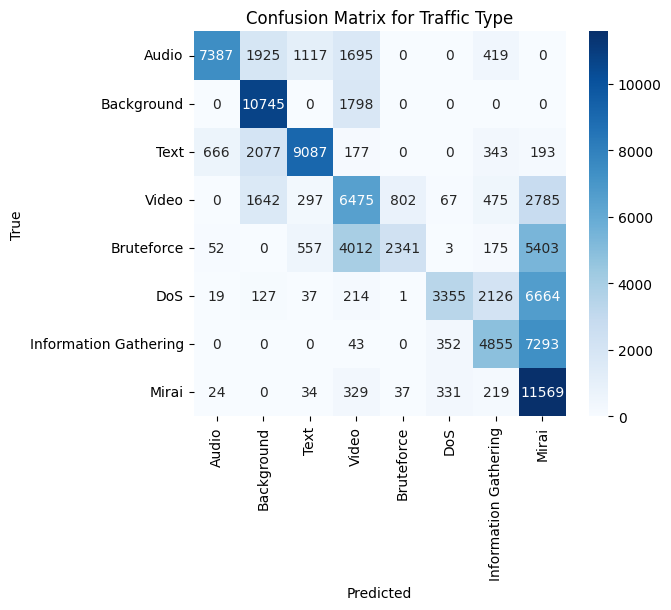

In [ ]:
# Neural Network TRAFFIC TYPE classification on the HDBSCAN-based dataset

NeuralNetworkClassification(training_HDBSCAN_ttype, testing_ttype, 'Traffic Type', batch_size=1024, epochs=200, lr=1e-3)